# Personal Information
Name: Robin van den Berg

StudentID: 11317345

Email: [**robin.vanden.berg@student.uva.nl**](robin.vanden.berg@student.uva.nl)

Submitted on: 15-03-2023

# Data Context
**In this section you should introduce the datasources and datasets which you will be working with. Explain where they are from as well as their domain. Give an overview of what the context of the data is. You should not spend more than 1 to 2 paragraphs here as the core information will be in the next section.**

The data presented in this EDA is from Elsevier and is named Canary. The dataset is a subset of the Embase database. The Embase database is a biomedical research database maintained by the published Elsevier. The datbase is indexed by Emtree indexing terms, Elsevier’s authoritative life science thesaurus. The dataset contains the abstracts, keywords, titles and some supplemental information about articles present in this database in combination with the Emtree terms that are linked in to articles.

In this project, the Emtree terms are the labels that we want to assign to the papers. The Emtree terms are polyhierarchical, meaning that we have multiple tree structures that link the terms, while terms can still occur in two (or more) hierarchies at the same time. The Emtree terms index the entire text and pose a multilabel classification problem where the labels are not independent.

# Data Description

**Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.**

As you can see, you are in a jupyter notebook environment here. This means that you should focus little on writing text and more on actually exploring your data. If you need to, you can use the amsmath environment in-line: $e=mc^2$ or also in separate equations such as here:

\begin{equation}
    e=mc^2 \mathrm{\space where \space} e,m,c\in \mathbb{R}
\end{equation}

Furthermore, you can insert images such as your data aggregation diagrams like this:

![image](example.png)

In [2]:
# Imports
import ast
import os
import sys
import itertools
from itertools import combinations
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
from tqdm import tqdm

In [3]:
sys.path.append(
  os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data Loading

In [5]:
loc_dict = {
    'train': '../data/raw/canary/set_B_train_kw.csv',
    'val': '../data/raw/canary/set_B_val_kw.csv',
    'test': '../data/raw/canary/set_B_test_kw.csv',
    'xml':  '../data/raw/canary/original_xml_files/20210210_11422_194_1.xml',
    'xml_csv':  '../data/raw/canary/original_xml_files/all_articles_diff_labels.csv'
}
data_loader = DataLoader(loc_dict)

In [6]:
data_df = data_loader.load_xml_csv()

### Analysis 1: 
Explore content of the data. What is in there, and what are the mistakes.

Side note: The data was originally structured as separate XML files. This files have subsequently been parsed to csv, extracting the information that is likely to be useful and that we want to use for the research.

In [ ]:
# what does the data look like?
print(f"The shape of the data: {data_df.shape}")
print(f"The columns that we have for each article: \n {data_df.columns.tolist()}")
print(f"A sample of the data:")
data_df.head()

In [ ]:
# check the missing data for each column
percent_missing = data_df.isnull().sum() * 100 / len(data_df)

print(percent_missing.sort_values(ascending=False)[:10])

In [6]:
# see structure of author and organisation information
data_df['authors'] = data_df['authors'].apply(lambda x: ast.literal_eval(x))
data_df['organization'] = data_df['organization'].apply(lambda x: ast.literal_eval(x))

### Visualise the structure of the labels

In [ ]:
label_structure_df = pd.read_csv('../data/raw/canary/original_xml_files/paulas_labels.csv', sep=';')

In [ ]:
label_structure_df.head()

### Evaluate the occurrence and the co-occurrence of the different labels 


In [ ]:
def get_labels(row):
    """De-onehot encode a row."""
    return(list(row.index[row==1]))

In [ ]:
# get all labels in separate dataframe
label_columns = data_df.loc[:, ~data_df.columns.isin(['file_name', 'pui', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals', 'num_refs', 'date-delivered', 'labels_m', 'labels_a'])]
label_columns = label_columns.astype(int)

In [ ]:
label_occurrences = label_columns.sum().sort_values(ascending=False)
plt.figure(figsize = (10,5))
label_occurrences.plot(kind='bar')

In [ ]:
# inspect correlation between labels
corr = data_df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
def collect_pairs(lines, combination_size):
    """Count the co-occurrences of labels."""
    pair_counter = Counter()
    for line in lines:
        unique_tokens = sorted(set(line))  # exclude duplicates in same line and sort to ensure one word is always before other
        combos = combinations(unique_tokens, combination_size)
        pair_counter += Counter(combos)
    return pair_counter

In [ ]:
# get all the label combinations
label_columns.loc[:, 'label'] = label_columns.apply(lambda row:get_labels(row[label_columns.columns]), axis=1)
all_label_combinations = label_columns['label'].to_list()

In [ ]:
# the average number of labels:
print('This is the average number of labels: ', sum([len(l) for l in all_label_combinations])/len(all_label_combinations))
# print('The occurrence of each label: \n', label_columns.sum())

In [ ]:
# check the 30 most occurring label combinations
pairs = collect_pairs(all_label_combinations, combination_size=3)
pairs.most_common(10)

### Check the occurrence and co-occurrence of different author assigned keywords

In [ ]:
# get the average number of keywords
keywords_df = \
    data_df['keywords'].\
    dropna().\
    str.replace('[^|\w\s]','', regex=True).\
    str.lower().\
    str.split('|')

keywords_np = keywords_df.to_numpy()

keywords_list_merged = list(itertools.chain.from_iterable(keywords_np))

print(f'The number of unique keywords: {len(np.unique(keywords_list_merged))}')
unique, counts = np.unique(keywords_list_merged, return_counts=True)
print("The most occurring keywords in the dataset: ", sorted(list(zip(unique, counts)), key=lambda x: x[1], reverse=True)[:100])

### Check the author occurrences

In [ ]:
# first create a pivotted table with the article and the authors individually in a second column
author_df = data_df[['pui', 'authors']]
author_df = author_df.explode('authors').reset_index(drop=True)
author_qs = pd.json_normalize(author_df['authors']).reset_index(drop=True)
author_df = pd.concat([author_df, author_qs], axis=1)

In [ ]:
# look at the identifiable orcid ids and the occurrences there
print(f'The occurrences of orcid ids in the current dataset: \n', author_df["orcid"].value_counts()[:15])
print(f'The number of authors with only one article under their orcid: ', (author_df["orcid"].value_counts() == 1).sum())
print(f'The occurrences of index names (to see whether name matching would make sense, disclaimer it would not...): \n', author_df["indexed-name"].value_counts()[:20])
single_author_paper = author_df.drop_duplicates(subset=["instance-id", "author-id"])
print(f'The occurrences of authors ids in the current dataset: \n', single_author_paper['author-id'].value_counts()[:15])


### Clean text data

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords


In [ ]:
data_df['abstract'] = data_df['abstract'].fillna(data_df['abstract_2'])
text_df = data_df['abstract'].\
    dropna().\
    str.lower().\
    str.replace('[^|\w\s]','', regex=True).\
    apply(lambda x: remove_stopwords(x))

text_df


### Check the correlation of the labels with the keywords and the authors

In [ ]:
most_common_keywords = sorted(list(zip(unique, counts)), key=lambda x: x[1], reverse=True)
most_common_keywords = [keyword[0] for keyword in most_common_keywords[:100]]
onehot_keyword_df = pd.DataFrame(columns=most_common_keywords, index=data_df.index)

for column in onehot_keyword_df.columns:
    onehot_keyword_df[column] = data_df['keywords'].str.contains(column)

In [ ]:
keywords_labels = pd.concat([onehot_keyword_df.reset_index(drop=True), 
                             label_columns.reset_index(drop=True)], axis=1)
keywords_labels.fillna(0, inplace=True)
keywords_labels = keywords_labels.replace({True: 1, False: 0})


In [ ]:
# inspect correlation between labels
keywords_labels_corr = keywords_labels.corr(numeric_only=True)

In [ ]:
s = keywords_labels_corr.abs().unstack()
so = s.sort_values(kind="quicksort", ascending=False)

correlations = so.loc[(so != 1)].reset_index()
only_keywords_label_combinations = correlations.loc[(correlations['level_0'].isin(label_columns.columns)) & 
                                                    (correlations['level_1'].isin(onehot_keyword_df.columns))] 
print(f'These are the strongest correlations: \n{only_keywords_label_combinations[:25]}')
mask = np.triu(np.ones_like(keywords_labels_corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(keywords_labels_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Check the KNN capabilities for assigning multi-labels based on sematic similarity

Get the embeddings ready for the abstracts only.

In [ ]:
data_for_embedding = data_df.dropna(subset=['abstract'])
data_for_embedding.loc[:, 'labels_m'] = data_for_embedding['labels_m'].fillna('')
data_for_embedding.loc[:, 'list_label'] = data_for_embedding['labels_m'].str.split(',')

In [ ]:
n = 15000

In [ ]:
# tag the documents with all the labels
documents = [TaggedDocument(doc['abstract'], tags=[label]) 
             for i, doc in data_for_embedding[:n].iterrows()
             for label in doc['list_label']]

In [ ]:
print(len(documents))


In [ ]:
# spin up doc2vec model with the first n documents
model = Doc2Vec(documents, vector_size=256, window=5, min_count=10, workers=4)

In [ ]:
train_embedded_docs = np.array([model.infer_vector(doc) for i, doc in data_for_embedding.loc[:n, ['abstract']].iterrows()])
val_embedded_docs = np.array([model.infer_vector(doc) for i, doc in data_for_embedding.loc[n:n+10000, ['abstract']].iterrows()])

Check how easily we can predict labels based on semantic similarity. We shift the classification threshold and see how this effects the different metrics.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=25, n_jobs=-1)

thresholds = np.arange(0.1, 0.9, 0.2)
thresholds = [round(threshold, 2) for threshold in thresholds]
scorers = {'recall': recall_score, 'f1_score': f1_score, 'precision': precision_score}

print(thresholds)
scores = {scorer: {key: {} for key in thresholds} for scorer in scorers.keys()}
for label in label_columns.columns.difference(['label']):
    knn.fit(train_embedded_docs, data_for_embedding.loc[:n, label])
    prob_preds = knn.predict_proba(val_embedded_docs)[:,1]
    
    for threshold in thresholds:
        predictions = (prob_preds >= threshold).astype(bool)
#         print(f"Confusion matrix for {label}: \n", confusion_matrix(predictions, val_subset_df[label]))
        
        for scorer_name, scorer in scorers.items():
            score = scorer(predictions, data_for_embedding.loc[n:n+10000, label], zero_division=0)
#             print(f'{label}-{threshold:.1f}: \t \t The {scorer_name}: {score:.2f}')
            scores[scorer_name][threshold][label] = score

In [ ]:
# check the effect of the prediction threshold on the different scores
for scorer_name, scorer in scorers.items():
    df = pd.DataFrame(list(scores[scorer_name].values()), index=list(scores[scorer_name].keys())).transpose()
#     print(df.columns)
#     print(df.sort_values(by=0.1))
    fig, ax= plt.subplots(1,1, figsize=(10,5))
    ax.set_title(f'{scorer_name}')
    df.sort_values(by=0.1).plot.bar(ax=ax)
    ax.set_xlabel('Label')
    plt.legend(bbox_to_anchor = (1.35, 0.6), loc='center right')
    fig.tight_layout()
    fig.show()

### Compose different networks

In [7]:
import itertools
import networkx as nx

#### Create author network

In [ ]:
author_grouped_df = author_df[['pui', 'author-id']].groupby('author-id')
author_grouped_sizes_df = author_grouped_df.size()
author_grouped_get_combinations_df = author_grouped_df.apply(lambda x: list(itertools.combinations(x['pui'].tolist(), 2)))

In [ ]:
author_grouped_get_combinations_not_empty = author_grouped_get_combinations_df[author_grouped_get_combinations_df.map(lambda d: len(d)) > 0]

all_author_links = author_grouped_get_combinations_not_empty.to_frame().explode(0)
all_author_links[['from', 'to']] = pd.DataFrame(all_author_links[0].tolist(), index=all_author_links.index)
all_author_links.drop(0, inplace=True, axis=1)

In [ ]:
all_author_links

In [ ]:
author_graph = nx.from_pandas_edgelist(all_author_links, source='from', target='to')

In [ ]:
all_degrees = [v for _, v in nx.degree(author_graph)]
print(f'Average degree: {sum(all_degrees)/len(all_degrees)}')
plt.figure()
plt.xlim(0,50)
plt.hist(all_degrees, bins=1000)
plt.grid()

#### Create author-assigned keyword network 
Here, we create a network in which the edges are assigned based on matching keywords assigned by the authors.

Some of the articles are without keywords and are therefore isolated.

In [8]:
keywords_df = data_df.copy(deep=True)
keywords_df['keyword_lists'] = \
    keywords_df['keywords'].\
    dropna().\
    str.replace('[^|\w\s]','', regex=True).\
    str.replace(r'\r+|\n+|\t+', '', regex=True).\
    str.replace(r' +', ' ', regex=True).\
    str.lower().\
    str.split('|')

In [9]:
keywords_df = keywords_df[['pui', 'keyword_lists']]
keywords_df = keywords_df.explode('keyword_lists').reset_index(drop=True)
keywords_df.rename({'keyword_lists': 'keyword'}, inplace=True, axis=1)

In [10]:
keywords_df.dropna(subset=['keyword'], inplace=True)

In [11]:
keywords_df = keywords_df[keywords_df['keyword'] != '']
keywords_df = keywords_df[keywords_df['keyword'] != ' ']
keywords_df = keywords_df[keywords_df['keyword'] != '\n']

In [12]:
keywords_df.loc[keywords_df['keyword'] == ' ', 'keyword']

Series([], Name: keyword, dtype: object)

In [13]:
keywords_grouped_df = keywords_df.groupby('keyword')
keywords_grouped_sizes_df = keywords_grouped_df.size()
keywords_grouped_get_combinations_df = keywords_grouped_df.apply(lambda x: list(itertools.combinations(x['pui'].tolist(), 2)))

In [14]:
keywords_grouped_get_combinations_not_empty = \
    keywords_grouped_get_combinations_df[keywords_grouped_get_combinations_df.map(lambda d: len(d)) > 0]

all_keyword_links = keywords_grouped_get_combinations_not_empty.to_frame().explode(0)
all_keyword_links[['from', 'to']] = pd.DataFrame(all_keyword_links[0].tolist(), index=all_keyword_links.index)
all_keyword_links.drop(0, inplace=True, axis=1)

In [15]:
all_keyword_links

,from,to
keyword,,
adaptive sampling,2010405649,2010405716
agentbased simulation,2010405679,2010405740
aragonite,2010405659,2010405698
biomineral,2010405659,2010405698
competitive binding assay,2010405649,2010405716
...,...,...
εpolyllysine,2005483177,2010822363
μct,2007794477,2007434409
μct,2007794477,2006879601


In [23]:
keyword_graph = nx.from_pandas_edgelist(all_keyword_links.iloc[:3000000], source='from', target='to')

Average degree: 154.769681416388


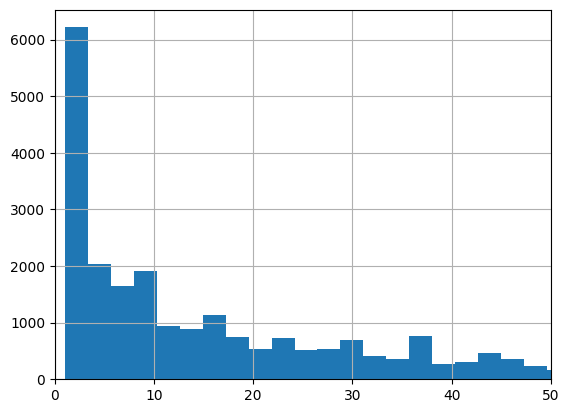

In [24]:
all_degrees = [v for _, v in nx.degree(keyword_graph)]
print(f'Average degree: {sum(all_degrees)/len(all_degrees)}')
plt.figure()
plt.xlim(0,50)
plt.hist(all_degrees, bins=1000)
plt.grid()